In [24]:
import os
import pandas as pd
import io
import unicodedata
import traceback


root_dir = 'coral_and_sponges_all/data/pub/data/paleo/coral'


In [25]:
root_files = os.listdir(root_dir)
root_files = root_files[0:2] + root_files[3:] # do not read from the do not use file
print(root_files)
sub_files_to_flatten = [[f'{r}/{f}' for f in os.listdir(f'{root_dir}/{r}')] for r in root_files]

#Flatten list of files into one list
sub_files = [f'{root_dir}/{item}' for sublist in sub_files_to_flatten for item in sublist]
# print(sub_files)

['atlantic', 'indian_ocean', 'caribbean', 'red_sea', 'central_pacific', 'west_pacific', 'east_pacific', 'south_china_sea']


In [26]:
len(sub_files)

227

In [17]:
def create_coral_file_df(filename):
    # print("reading")
    try:
        # Using a weird encoding to solve file read issue; see https://stackoverflow.com/questions/46000191/utf-8-codec-cant-decode-byte-0x92-in-position-18-invalid-start-byte
        coral_file = open(filename,'r', encoding="ascii", errors="ignore")
        file_in = coral_file.readlines()
        if file_in[0][0] != "#":
            print(f"'{filename}' does not begin with '#'; COMPLETELY IGNORING IT")
            return None

        for i in range(len(file_in)):
            line = file_in[i]
            if "Location:" in line:
                location = line.split(": ")[1].strip()

            if "Northernmost_Latitude:" in line:
                northernmost_lat = line.split(": ")[1].strip()
            if "Northmost Latitude" in line: # other variation of north lat
                northernmost_lat = line.split(": ")[1].strip().split(' ')[0]

            if "Southernmost_Latitude:" in line:
                southernmost_lat = line.split(": ")[1].strip()
            if "Southmost Latitude:" in line: # other variation of south lat
                southernmost_lat = line.split(": ")[1].strip().split(' ')[0]

            if "Easternmost_Longitude:" in line:
                easternmost_lat = line.split(": ")[1].strip()
            if "Eastmost Longitude:" in line:
                easternmost_lat = line.split(": ")[1].strip().split(' ')[0]

            if "Westernmost_Longitude:" in line:
                westernmost_lat = line.split(": ")[1].strip()
            if "Westmost Longitude:" in line:
                westernmost_lat = line.split(": ")[1].strip().split(' ')[0]

            if "Elevation:" in line:
                elevation = line.split(": ")[1].split(' ')[0].strip()
                if elevation == 'm':
                    elevation = ''
            if "Earliest_Year:" in line:
                earliest_year = line.split(": ")[1].strip()
            if "Most_Recent_Year:" in line:
                most_recent_year = line.split(": ")[1].strip()
            if "Species_Name:" in line:
                species = line.split(": ")[1].strip('\n').strip()
            if not line.startswith('#'):
                if not line[0].isprintable():
                    continue # Don't break on weird, non-printable characters
                elif len(line.strip()) == 0:
                    continue
                else:
                    age_line = i
                    #print('exited at line: ' + str(i))
                    extracted = ' '.join(file_in[age_line:])
                    break #exit the for loop, we (theorerically) have obtained the data!

        lat = (float(northernmost_lat) + float(southernmost_lat)) / 2
        lon = (float(easternmost_lat) + float(westernmost_lat)) / 2

        data = io.StringIO(extracted)
        df = pd.read_csv(data, sep="\t", error_bad_lines=False)

        df.columns = (map(lambda x: x.lower(), df.columns))

        # find the correct 'age' column
        if 'age' not in df.columns:
            if 'age_ad' in df.columns:
                df['age'] = df['age_ad']
            elif 'age_calad' in df.columns:
                df['age'] = df['age_calad']
            elif 'age_int' in df.columns:
                df['age'] = df['age_int']
            elif 'age_ce' in df.columns:
                df['age'] = df['age_ce']
            elif 'age_ce_d180' in df.columns:
                df['age'] = df['age_ce_d180']
            elif 'time' in df.columns:
                df['age'] = df['time']
            elif 'date' in df.columns:
                df['age'] = df['date']
            elif 'year' in df.columns:
                df['age'] = df['year']
            elif 'year ' in df.columns:
                df['age'] = df['year ']
            elif 'year_ce' in df.columns:
                df['age'] = df['year_ce']
            else:
                print("No 'age' column header detected.")

        #print(df['age'])

        #find the correct d18O column
        if 'd18o' not in df.columns:
            count = 0
            for col in df.columns:
                # we are assuming that the first col with d18O is the one we want
                if 'd18o' in col:
                    if 'recon' in col: # we don't want reconstructed d18O values
                        continue
                    df['d18o'] = df[col]
                    break
        
        #print(df['d18o'])

        df = df[['age', 'd18o']]
        df = df[df['d18o'] != 'NAN']

        # average the d18O values across the years
        df['year']  = df['age'].apply(lambda x: str(x).strip()[0:4])
        df = df.groupby(by="year")["d18o"].mean().reset_index('year')

        df['lat'] = lat
        df['lon'] = lon
        df['elevation'] = elevation
        
        try:
            species
            if species == '':
                print(f'{filename} has '' for species')
            df['species'] = species
        except NameError:
            # print(f'{filename} does not list any species (Other).')
            df['species'] = 'Other'

        return(df)

        # except Exception as e:
        #     print("exception2")
        #     print("ERROR : "+str(e))
        #     # print("Error on line {}".format(sys.exc_info()[-1].tb_lineno))
            # print('hi')
    except Exception as e:
        if "Is a directory" not in str(e):
            print(filename)
            print("ERROR : " +str(e))
        #traceback.print_exception(type(e), e, e.__traceback__)

Quick Proof of Concept for the function above:

In [5]:
#filename = f'{root_dir}/atlantic/barbados_coral18o.txt'
# filename = f'{root_dir}/atlantic/goodkin2008-sst_noaa.txt'
# filename = f'{root_dir}/atlantic/smith2006-lk1.txt'
# filename = f'{root_dir}/red_sea/felis20?00_noaa.txt'
# filename = f'{root_dir}/atlantic/moses2006-side_noaa.txt'
# filename = f'{root_dir}/atlantic/barbados_coral18o.txt'
filename = f'{root_dir}/west_pacific/gorman2012.txt'
#'swart1998-st-1_noaa.txt'

create_coral_file_df(filename)

/var/folders/ws/d7dc4bz53q3_26hs2vbmg8600000gn/T/ipykernel_50149/1638512403.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  create_coral_file_df(filename)


,year,d18o,lat,lon,elevation,species
0,1842,-4.486000,15.94,166.04,8,Porites lutea
1,1843,-4.609167,15.94,166.04,8,Porites lutea
2,1844,-4.520833,15.94,166.04,8,Porites lutea
3,1845,-4.412500,15.94,166.04,8,Porites lutea
4,1846,-4.581667,15.94,166.04,8,Porites lutea
...,...,...,...,...,...,...
161,2003,-4.946667,15.94,166.04,8,Porites lutea
162,2004,-4.991667,15.94,166.04,8,Porites lutea
163,2005,-5.115000,15.94,166.04,8,Porites lutea
164,2006,-5.008333,15.94,166.04,8,Porites lutea


In [29]:
all_coral_df = pd.DataFrame(columns=['age', 'd18O', 'lat', 'lon', 'elevation', 'species'])
for file in sub_files:
    #print(file)
    coral_df = create_coral_file_df(file)
    try:
        all_coral_df = pd.concat([all_coral_df, coral_df])
    except Exception as e:
        if "Is a directory" not in str(e):
            print('Error: ' + str(e))
            traceback.print_exception(type(e), e, e.__traceback__)

del all_coral_df['age']
del all_coral_df['d18O']

all_coral_df.reset_index
all_coral_df


/var/folders/ws/d7dc4bz53q3_26hs2vbmg8600000gn/T/ipykernel_50149/1673132442.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  coral_df = create_coral_file_df(file)
b'Skipping line 219: expected 5 fields, saw 6\n'


coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/abram2008-d18o_noaa.txt
ERROR : Could not convert -5.50-5.46-5.52-5.55-5.50-5.40-5.30-5.20-5.24 to numeric
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/zinke2008_noaa.txt
ERROR : Could not convert -4.650-4.865-4.883 to numeric
coral_and_sponges_all/data/pub/data/paleo/coral/indian_ocean/nakamura2009_noaa.txt
ERROR : Could not convert -5.083-4.873-4.506-4.755-4.545-4.461-4.253-3.957-4.601-4.799-4.785-4.902 to numeric
coral_and_sponges_all/data/pub/data/paleo/coral/central_pacific/grothe2019-x12-d2-5.txt does not list any species (Other).
coral_and_sponges_all/data/pub/data/paleo/coral/central_pacific/grothe2019-x12-d2-1.txt does not list any species (Other).
coral_and_sponges_all/data/pub/data/paleo/coral/central_pacific/grothe2019-x12-d1-4.txt does not list any species (Other).
coral_and_sponges_all/data/pub/data/paleo/coral/central_pacific/grothe2019-x13-fs21-38.txt does not list any species (Other).
coral_an

b'Skipping line 1419: expected 3 fields, saw 4\n'


coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/cole1993-ldgo-39_noaa.txt
ERROR : Could not convert -5.05-5.056-4.743-4.697-4.844-5.24-5.062-4.826-4.899-4.812-5.168-4.723 to numeric
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/hon-tre2014.txt does not list any species (Other).
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/cole1993-ldgo-44_noaa.txt
ERROR : Could not convert -4.769-4.573-4.685-4.211-4.37-4.805-4.812 to numeric
coral_and_sponges_all/data/pub/data/paleo/coral/west_pacific/urban2000_noaa.txt has  for species
coral_and_sponges_all/data/pub/data/paleo/coral/east_pacific/sanchez2020-palmyra.txt
ERROR : list index out of range
coral_and_sponges_all/data/pub/data/paleo/coral/east_pacific/sanchez2020-fanning.txt has  for species
coral_and_sponges_all/data/pub/data/paleo/coral/east_pacific/sanchez2016-clarion.txt
ERROR : list index out of range
coral_and_sponges_all/data/pub/data/paleo/coral/east_pacific/cobb2003-ch9_noaa.txt has  for sp

,lat,lon,elevation,species,year,d18o
0,11.170000,-60.850000,-4,Montastaea faveolata,1927,-4.067500
1,11.170000,-60.850000,-4,Montastaea faveolata,1928,-3.865000
2,11.170000,-60.850000,-4,Montastaea faveolata,1929,-3.865000
3,11.170000,-60.850000,-4,Montastaea faveolata,1930,-4.007500
4,11.170000,-60.850000,-4,Montastaea faveolata,1931,-4.040000
...,...,...,...,...,...,...
40,20.666667,116.833333,-5,Porites sp.,2008,-5.474000
41,20.666667,116.833333,-5,Porites sp.,2009,-5.249917
42,20.666667,116.833333,-5,Porites sp.,2010,-5.299417
43,20.666667,116.833333,-5,Porites sp.,2011,-5.397417


Caught this typo :)

In [ ]:
all_coral_df = all_coral_df.replace(to_replace ="Porites spp.",
                 value ="Porites sp.")

In [36]:
all_coral_df.to_csv('all_coral.csv')


In [30]:
all_coral_df

,lat,lon,elevation,species,year,d18o
0,11.170000,-60.850000,-4,Montastaea faveolata,1927,-4.067500
1,11.170000,-60.850000,-4,Montastaea faveolata,1928,-3.865000
2,11.170000,-60.850000,-4,Montastaea faveolata,1929,-3.865000
3,11.170000,-60.850000,-4,Montastaea faveolata,1930,-4.007500
4,11.170000,-60.850000,-4,Montastaea faveolata,1931,-4.040000
...,...,...,...,...,...,...
40,20.666667,116.833333,-5,Porites sp.,2008,-5.474000
41,20.666667,116.833333,-5,Porites sp.,2009,-5.249917
42,20.666667,116.833333,-5,Porites sp.,2010,-5.299417
43,20.666667,116.833333,-5,Porites sp.,2011,-5.397417


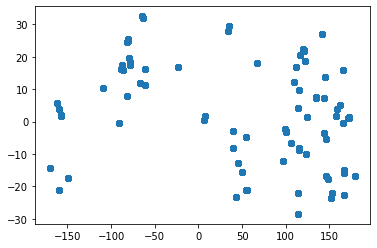

In [9]:
import matplotlib.pyplot as plt
plt.scatter(all_coral_df['lon'], all_coral_df['lat'])


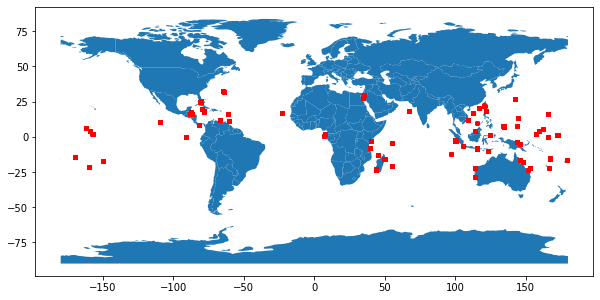

In [10]:
import shapely
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(all_coral_df['lon'], 
                                    all_coral_df['lat'])]

gdf = GeoDataFrame(all_coral_df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Looking at the lat/lon of our data, it looks like we will have a model heavily biased towards tropical regions, and maybe south east Asia.

In [ ]:
coral_file = 'swart1998-st-1_noaa.txt'
# Example of file with -noaa extension
file1 = open(coral_file,'r')
print(file1.read())
file1.close()

Gather metadata info! (site lat/lon & years of study)

In [ ]:
file1 = open(coral_file,'r')
file_in = file1.readlines()

for line in file_in:
    if "Location:" in line:
        location = line.split(": ")[1]
    if "Northernmost_Latitude:" in line:
        northernmost_lat = line.split(": ")[1]
    if "Southernmost_Latitude:" in line:
        southernmost_lat = line.split(": ")[1]
    if "Easternmost_Longitude:" in line:
        easternmost_lat = line.split(": ")[1]
    if "Westernmost_Longitude:" in line:
        westernmost_lat = line.split(": ")[1]
    if "Elevation:" in line:
        elevation = line.split(": ")[1].split(' ')[0]
    if "Earliest_Year:" in line:
        earliest_year = line.split(": ")[1]
    if "Most_Recent_Year:" in line:
        most_recent_year = line.split(": ")[1]
    if "Species_Name:" in line:
        species = line.split(": ")[1].strip('\n')

lat = (float(northernmost_lat) + float(southernmost_lat)) / 2
lon = (float(easternmost_lat) + float(westernmost_lat)) / 2



In [ ]:
age_line = 0
file1 = open(coral_file,'r')
with file1 as f:
    lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith('age'):
            print(i)
            age_line = i
            break
    extracted = ' '.join(lines[age_line:])
    print(extracted)

In [ ]:
data = io.StringIO(extracted)
df_test = pd.read_csv(data, sep="\t")
df_test.head()

Just grab `age` and `d18O` columns! And remove NAN values. 

In [ ]:
df_test_d18O = df_test[['age', 'd18O']]
df_test_d18O = df_test_d18O[df_test_d18O['d18O'] != 'NAN']
df_test_d18O['lat'] = lat
df_test_d18O['lon'] = lon
df_test_d18O['elevation'] = elevation
df_test_d18O['species'] = species
df_test_d18O